In [516]:
import pandas as pd
import re
import nltk
from nltk.tokenize import PunktSentenceTokenizer
import os

[A-Za-zА-Яа-яЁё]+|\d+|[^\w\s]|\s

Первый ru ner-датасет https://github.com/AlexKly/Detailed-NER-Dataset-RU

Dataset is labeled in BIOLU format, where:
- B - beginning token
- I - inner token
- O - other token
- L - last token
- U - unite token

Dataset labeled (contained) following tags:

LOC tags:
- REGION
- COUNTRY
- CITY
- DISTRICT
- STREET
- HOUSE

PER tags:
- LAST_NAME
- FIRST_NAME
- MIDDLE_NAME



Второй ru ner-датасет https://huggingface.co/datasets/iluvvatar/RuNNE

Третий ru ner-датасет https://huggingface.co/datasets/tner/wikineural

In [101]:
self_path_df = 'dataset/ru/self/original.xlsx'

In [102]:
self_df = pd.read_excel(self_path_df)
self_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text_id  209 non-null    int64 
 1   text     209 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


In [107]:
self_df.tail()

,text_id,text
204,205,Продам диван. ИП Морозов И.С. (ИНН 29047654321...
205,206,"Клиент Петрова А.Д., карта **** 5678. 25.10 в ..."
206,207,"Катя, передай документы на квартиру:\nАдрес: М..."
207,208,"Я: Заберу заказ у входа в офис (ул. Кирова, 5)..."
208,209,Встречаемся 27.10 в 15:00 у кафе «Старбакс» (у...


In [104]:
nltk_data_dir_name = 'nltk_data'
local_nltk_data_dir = os.path.join(os.getcwd(), nltk_data_dir_name)

if not os.path.exists(local_nltk_data_dir):
    os.makedirs(local_nltk_data_dir, exist_ok=True)

In [105]:
nltk.data.path.clear()
nltk.data.path.append(local_nltk_data_dir)
print(nltk.data.path)

['c:\\Users\\vlaxd\\OneDrive\\Рабочий стол\\4_course\\hse-personal-data-anonymisation\\src\\nltk_data']


In [62]:
nltk.download('punkt_tab', download_dir=local_nltk_data_dir)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\Users\vlaxd\OneDrive\Рабочий стол\4_course\hse-
[nltk_data]     personal-data-anonymisation\src\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Токенизация:
- токенизация по предложениям `text2sentence`
- токенизация по словам `sentence2word`

https://natasha.github.io/razdel/

In [753]:
from razdel import sentenize

def text2sentence(text: str) -> list[str]:
    # return nltk.sent_tokenize(text=text, language='russian')
    
    sentences = []
    prev_stop = None
    
    sentenize_text = sentenize(text)
    sentenize_text_len = len(list(sentenize(text))) # почему то преобразования изменяют sentenize_text, поэтому подсчитаем кол-во так
    for i, substr in enumerate(sentenize_text):
        if i == 0:
            prev_stop = substr.stop
            if substr.start > 0:
                sentences.append(text[0:prev_stop])
                continue
            sentences.append(text[substr.start:prev_stop])
            continue
            
        if i != 0 and i == sentenize_text_len - 1:
            sentences.append(text[prev_stop:len(text)])
            continue
        
        sentences.append(text[prev_stop:substr.stop])
        prev_stop = substr.stop
        
    return sentences

def sentence2word(text: str):
    custom_pattern = re.compile(r"[A-Za-zА-Яа-яЁё]+|\d+|[^\w\s]|\s")
    re_result = custom_pattern.finditer(text)
    starts = [match.start() for match in re_result]
    ends = [match.end() for match in re_result]
    matchs = [match.group() for match in re_result]
    return starts, ends, matchs
    

In [754]:
text = '''Сегодня я купил машину!
Мне очень нравится моя машина!!!

.
'''

text2 = 'Меня зовут Платонов Владислав Алексеевич. Я родился 08.02.2003!'

text2sentence(text2)

['Меня зовут Платонов Владислав Алексеевич.', ' Я родился 08.02.2003!']

In [752]:
print(len(list(sentenize(text2))))
for i in sentenize(text2):
    print(i)

2
Substring(0, 41, 'Меня зовут Платонов Владислав Алексеевич.')
Substring(42, 63, 'Я родился 08.02.2003!')


In [107]:
self_df['sentence'] = self_df['text'].apply(text2sentence) # построчная токенизация внутри df
self_df = self_df.explode('sentence').reset_index(drop=True) # раскрытие результата токенизации list -> item
self_df['sentence_id'] = (self_df.groupby('text_id').cumcount() + 1) # нумерация предложений внутри текста
self_df.head()

,text_id,text,sentence,sentence_id
0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1
1,1,"Александра Михайловна Козлова, ведущий аналити...","По её мнению, нейросетевые модели уже сейчас д...",2
2,1,"Александра Михайловна Козлова, ведущий аналити...","""Главное — обеспечить этичное использование те...",3
3,2,"Сергей Владимирович Игнатьев, основатель старт...","Сергей Владимирович Игнатьев, основатель старт...",1
4,2,"Сергей Владимирович Игнатьев, основатель старт...","Проект, разработанный при поддержке международ...",2


In [108]:
self_df['word_info'] = self_df['sentence'].apply(sentence2word)
self_df = self_df.explode('word_info').reset_index(drop=True)
self_df[['start', 'end', 'word']] = pd.DataFrame(self_df['word_info'].tolist(), index=self_df.index)
self_df = self_df.drop('word_info', axis=1)
self_df.head()


,text_id,text,sentence,sentence_id,start,end,word
0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра
1,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,10,11,
2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна
3,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,21,22,
4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова


In [ ]:
# self_df.to_excel('dataset/ru/self/modified_origin.xlsx')

Переделать индексы start и end для текста в ообщем, затем удалить пробелы

(Проблема для исследования) Код подразделения в паспорте последнии цифры телефона 888-888 (используем lstm нейросети вместо rule based для номеров телефонов)

In [3]:
modified_self_df_path = 'dataset/ru/self/modified_origin.xlsx'

In [445]:
m_df = pd.read_excel(modified_self_df_path)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7309 entries, 0 to 7308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   7309 non-null   int64 
 1   text_id      7309 non-null   int64 
 2   text         7309 non-null   object
 3   sentence     7309 non-null   object
 4   sentence_id  7309 non-null   int64 
 5   start        7309 non-null   int64 
 6   end          7309 non-null   int64 
 7   word         7309 non-null   object
 8   ner          7309 non-null   object
 9   pos          7309 non-null   object
 10  word_id      7309 non-null   int64 
 11  ner_id       7309 non-null   int64 
 12  pos_id       7309 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 742.4+ KB


In [119]:
drop_columns = ['Unnamed: 0']
m_df = m_df.drop(columns=drop_columns)
m_df.head()

,text_id,text,sentence,sentence_id,start,end,word,ner_format,ner_tag
0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U,PER_FITST_NAME
1,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,10,11,NaN,NaN,NaN
2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U,PER_MIDDLE_NAME
3,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,21,22,NaN,NaN,NaN
4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U,PER_LAST_NAME


In [120]:
pd.options.plotting.backend = 'holoviews' # изменение бэкенда pandas для построения интерактивных графиков

In [121]:
unique_ner_tags = m_df['ner_tag'].value_counts()

d = unique_ner_tags.plot(kind='barh',
                     title='Количество уникальных тегов в корпусе',
                     git=True,
                     width=1000,
                     height=500)
d

:Bars   [ner_tag]   (count)

Заполнение пропусков в столбце ner_format - O

Изменение пропусков в столбце ner_tag - ""

Изменение пропусков в столбце word - " "

In [122]:
m_df.fillna({'ner_format':'O'}, inplace=True)
m_df.fillna({'ner_tag':''}, inplace=True)
m_df.fillna({'word':' '}, inplace=True)
m_df.head()

,text_id,text,sentence,sentence_id,start,end,word,ner_format,ner_tag
0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U,PER_FITST_NAME
1,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,10,11,,O,
2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U,PER_MIDDLE_NAME
3,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,21,22,,O,
4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U,PER_LAST_NAME


In [123]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text_id      10789 non-null  int64 
 1   text         10789 non-null  object
 2   sentence     10789 non-null  object
 3   sentence_id  10789 non-null  int64 
 4   start        10789 non-null  int64 
 5   end          10789 non-null  int64 
 6   word         10789 non-null  object
 7   ner_format   10789 non-null  object
 8   ner_tag      10789 non-null  object
dtypes: int64(4), object(5)
memory usage: 758.7+ KB


Объеденим ner_format и ner_tag в ner

In [124]:
m_df.loc[m_df['ner_format'] != 'O', 'ner_format'] += '-' # добавляем постфикс для объединения формата и тэга
m_df['ner'] = m_df['ner_format'] + m_df['ner_tag']
m_df.head()

,text_id,text,sentence,sentence_id,start,end,word,ner_format,ner_tag,ner
0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U-,PER_FITST_NAME,U-PER_FITST_NAME
1,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,10,11,,O,,O
2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U-,PER_MIDDLE_NAME,U-PER_MIDDLE_NAME
3,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,21,22,,O,,O
4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U-,PER_LAST_NAME,U-PER_LAST_NAME


In [125]:
m_df.drop(columns=['ner_format', 'ner_tag'], inplace=True)

Пересчитаем индекс start и end для всего текста в целом

In [126]:
text_ids = m_df['text_id'].unique()

for text_id in text_ids:
    
    offset = 0 # смещение позиции относительно текста
    sentence_ids = m_df.loc[m_df['text_id'] == text_id, 'sentence_id'].unique()
    
    for sentence_id in sentence_ids: 
        
        m_df.loc[(m_df['text_id'] == text_id) & (m_df['sentence_id'] == sentence_id), 'start'] += offset
        m_df.loc[(m_df['text_id'] == text_id) & (m_df['sentence_id'] == sentence_id), 'end'] += offset
        
        offset = m_df.loc[(m_df['text_id'] == text_id) & (m_df['sentence_id'] == sentence_id), 'end'].iloc[-1]
        
        

In [ ]:
def reread_pos_indx(sentence_ids: list[int], stats: list[int], ends: list[int]):
    '''Обвноление позиций слова start и end для всего текста в целом'''
    unique_setence_ids = set(sentence_ids)
    offset = 0 # смещение позиции относительно текста
    for i, sentence_id in enumerate(sentence_ids):
        pass
    

In [184]:
m_df.head()

,text_id,text,sentence,sentence_id,start,end,word,ner
0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U-PER_FITST_NAME
1,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,10,11,,O
2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U-PER_MIDDLE_NAME
3,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,21,22,,O
4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U-PER_LAST_NAME


In [92]:
pd.set_option('display.max_rows', 1000)

Сохранение символов \n или других методом:

```
import nltk

def tokenize_sentences_with_newlines(text):
    # Уникальный маркер для замены \n
    placeholder = "___NEWLINE___"
    
    # Заменяем все \n на маркер
    processed_text = text.replace('\n', placeholder)
    
    # Токенизируем предложения
    sentences = nltk.sent_tokenize(processed_text)
    
    # Восстанавливаем \n в каждом предложении
    sentences = [s.replace(placeholder, '\n') for s in sentences]
    
    return sentences

# Пример использования
text = "Это первое предложение.\nА это второе. И третье.\n"
result = tokenize_sentences_with_newlines(text)
print(result)
# Вывод: ['Это первое предложение.\n', 'А это второе.', 'И третье.\n']
```

In [690]:
def token2id(tokens: list, add_uknn: bool = False):
    if add_uknn:
        tokens = list(tokens)
        tokens.append('UNKN') # для неизместных слов и частей речи
    
    vocab = list(set(tokens))
    
    token_id = {token:id + 1 for id,token in enumerate(vocab)} # + 1 для индекса паддинга
    id_token = {id + 1:token for id,token in enumerate(vocab)} # + 1 для индекса паддинга
    
    return token_id, id_token

Функция для выделения части речи токена

In [636]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def word2pos(word: str) -> str:
    
    result = morph.parse(word)
    
    if 'Name' in result[0].tag: return 'Name'
    if 'Surn' in result[0].tag: return 'Surn'
    if 'Patr' in result[0].tag: return 'Patr'
    if 'PNCT' in result[0].tag: return 'PNCT'
    if 'NUMB' in result[0].tag: return 'NUMB'
    if 'LATN' in result[0].tag: return 'LATN'
    
    if result[0].tag.POS: return str(result[0].tag.POS)
    
    return 'UNKN'

In [758]:
a = 'efe fe fe'
start = 1
end = 3
a = a[:start] + "1"*(end-start) + a[end:]
a

'e11 fe fe'

Удалим все пустые строки и пробелы

In [233]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text_id      10789 non-null  int64 
 1   text         10789 non-null  object
 2   sentence     10789 non-null  object
 3   sentence_id  10789 non-null  int64 
 4   start        10789 non-null  int64 
 5   end          10789 non-null  int64 
 6   word         10789 non-null  object
 7   ner          10789 non-null  object
dtypes: int64(4), object(4)
memory usage: 674.4+ KB


In [324]:
m_df.drop(m_df[(m_df['word'] == ' ')
               | (m_df['word'] == '\u00A0') # неразрывный пробел
               | (m_df['word'] == '\u202F') # узкий неразрывный пробел
               | (m_df['word'] == '\u2009') # узкий пробел
               | (m_df['word'] == '\ufe0f') # невидимый селектор цвета эмоджи
               | (m_df['word'] == '') 
               | (m_df['word'] == '\n') 
               | (m_df['word'] == '\t')].index, inplace=True)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7309 entries, 0 to 10788
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text_id      7309 non-null   int64 
 1   text         7309 non-null   object
 2   sentence     7309 non-null   object
 3   sentence_id  7309 non-null   int64 
 4   start        7309 non-null   int64 
 5   end          7309 non-null   int64 
 6   word         7309 non-null   object
 7   ner          7309 non-null   object
 8   pos          7309 non-null   object
dtypes: int64(4), object(5)
memory usage: 571.0+ KB


In [446]:
m_df.head(10)

,Unnamed: 0,text_id,text,sentence,sentence_id,start,end,word,ner,pos,word_id,ner_id,pos_id
0,0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U-PER_FITST_NAME,NOUN,1073,5,8
1,2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U-PER_MIDDLE_NAME,NOUN,1294,26,8
2,4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U-PER_LAST_NAME,NOUN,1119,48,8
3,5,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,29,30,",",O,PNCT,208,49,16
4,7,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,31,38,ведущий,O,ADJF,337,49,17
5,9,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,39,47,аналитик,O,NOUN,20,49,8
6,11,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,48,54,научно,O,ADVB,668,49,2
7,12,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,54,55,-,O,PNCT,423,49,16
8,13,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,55,73,исследовательского,O,ADJF,1046,49,17
9,15,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,74,80,центра,O,NOUN,1302,49,8


In [468]:
morph.parse('+')[0].tag.grammemes

frozenset({'UNKN'})

Установим значения POS для токенов

In [463]:
m_df['pos'] = [word2pos(word) for word in m_df['word']]
m_df.head()

,Unnamed: 0,text_id,text,sentence,sentence_id,start,end,word,ner,pos,word_id,ner_id,pos_id
0,0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U-PER_FITST_NAME,Name,1074,6,9
1,2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U-PER_MIDDLE_NAME,Patr,1295,27,9
2,4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U-PER_LAST_NAME,Surn,1120,49,9
3,5,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,29,30,",",O,PNCT,209,50,17
4,7,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,31,38,ведущий,O,ADJF,338,50,18


In [469]:
m_df.loc[m_df['pos'] == 'UNKN'].head()

,Unnamed: 0,text_id,text,sentence,sentence_id,start,end,word,ner,pos,word_id,ner_id,pos_id
312,518,8,"...Сие письмо составлено в лето 1812-е, месяца...","...Сие письмо составлено в лето 1812-е, месяца...",1,55,57,въ,O,UNKN,1410,50,16
315,522,8,"...Сие письмо составлено в лето 1812-е, месяца...","...Сие письмо составлено в лето 1812-е, месяца...",1,60,61,й,O,UNKN,1371,50,16
384,634,10,"Эй, встречаемся завтра в 19:30 🕢 у кинотеатра!...","Эй, встречаемся завтра в 19:30 🕢 у кинотеатра!",1,31,32,🕢,O,UNKN,1618,50,16
411,676,10,"Эй, встречаемся завтра в 19:30 🕢 у кинотеатра!...","Напомни Лене, что её ДР 12-го числа 🎉",3,127,128,🎉,O,UNKN,1525,50,16
412,677,11,🔥 Только с 1 по 10 декабря скидка 50% на зимню...,🔥 Только с 1 по 10 декабря скидка 50% на зимню...,1,0,1,🔥,O,UNKN,566,50,16


In [ ]:
word2id_dict, id2word_dict = token2id(m_df['word'], add_uknn=True)
ner2id_dict, id2ner_dict = token2id(m_df['ner'])
pos2id_dict, id2pos_dict = token2id(m_df['pos'])

m_df['word_id'] = (m_df['word']).map(word2id_dict)
m_df['ner_id'] = (m_df['ner']).map(ner2id_dict)
m_df['pos_id'] = (m_df['pos']).map(pos2id_dict)

Сохарним текущий корпус слов, частей речи и тэгов в json

In [735]:
import json

known_tokens_poses_tags = {
    'token2id': word2id_dict,
    'id2token': id2word_dict,
    'tag2id': ner2id_dict,
    'id2tag': id2ner_dict,
    'pos2id': pos2id_dict,
    'id2pos': id2pos_dict
}

with open('known_tokens_poses_tags.json', 'w', encoding='utf-8') as file:
    json.dump(known_tokens_poses_tags, file, ensure_ascii=False, indent=4)

In [745]:
a = None
with open('known_tokens_poses_tags.json', 'r', encoding='utf-8') as file:
    a = json.load(file)
print(a)
print(a['token2id']['UNKN'])
print(a['pos2id']['UNKN'])

{'token2id': {'Решение': 1, '7701234567': 2, '123': 3, 'центов': 4, 'Позвонить': 5, 'можно': 6, 'пункт': 7, 'посылку': 8, 'кот': 9, 'делу': 10, 'Рекомендации': 11, 'числа': 12, '29': 13, 'восстановление': 14, '98': 15, 'Ваш': 16, 'действителен': 17, 'договора': 18, 'штрафа': 19, 'МСК': 20, 'аналитик': 21, 'потенциал': 22, 'Ильинична': 23, '😊': 24, 'искусственного': 25, 'демонстрируют': 26, 'лет': 27, 'датой': 28, ']': 29, 'область': 30, 'Верх': 31, 'CID': 32, 'паспорте': 33, 'Николаевич': 34, 'Оспорить': 35, 'Заберу': 36, '540': 37, 'Марина': 38, 'Арендодатель': 39, '1122': 40, '16': 41, 'Camry': 42, 'Прошу': 43, '375': 44, 'справки': 45, 'Сергей': 46, '010': 47, 'Райффайзенбанк': 48, 'Императорского': 49, '520112345678': 50, 'обязательна': 51, 'N': 52, 'проведенному': 53, 'квантовые': 54, 'МФЦ': 55, 'опыт': 56, '131': 57, 'браке': 58, '22': 59, '1980': 60, 'Добрый': 61, '007': 62, 'Заявитель': 63, '5200': 64, 'Сие': 65, 'поддержки': 66, 'международный': 67, 'нарушения': 68, 'тел': 69,

In [640]:
m_df.head(10)

,Unnamed: 0,text_id,text,sentence,sentence_id,start,end,word,ner,pos,word_id,ner_id,pos_id
0,0,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,0,10,Александра,U-PER_FITST_NAME,Name,1074,6,7
1,2,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,11,21,Михайловна,U-PER_MIDDLE_NAME,Patr,1295,27,1
2,4,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,22,29,Козлова,U-PER_LAST_NAME,Surn,1120,49,22
3,5,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,29,30,",",O,PNCT,209,50,19
4,7,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,31,38,ведущий,O,ADJF,338,50,20
5,9,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,39,47,аналитик,O,NOUN,21,50,11
6,11,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,48,54,научно,O,ADVB,669,50,4
7,12,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,54,55,-,O,PNCT,424,50,19
8,13,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,55,73,исследовательского,O,ADJF,1047,50,20
9,15,1,"Александра Михайловна Козлова, ведущий аналити...","Александра Михайловна Козлова, ведущий аналити...",1,74,80,центра,O,NOUN,1304,50,11


In [641]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7309 entries, 0 to 7308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   7309 non-null   int64 
 1   text_id      7309 non-null   int64 
 2   text         7309 non-null   object
 3   sentence     7309 non-null   object
 4   sentence_id  7309 non-null   int64 
 5   start        7309 non-null   int64 
 6   end          7309 non-null   int64 
 7   word         7309 non-null   object
 8   ner          7309 non-null   object
 9   pos          7309 non-null   object
 10  word_id      7309 non-null   int64 
 11  ner_id       7309 non-null   int64 
 12  pos_id       7309 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 742.4+ KB


In [473]:
final_df = m_df.groupby(
    ['text_id', 'sentence_id'], as_index=False
)[['word', 'start', 'end', 'ner', 'pos', 'word_id', 'ner_id', 'pos_id']].agg(lambda x: list(x))

final_df.head()

,text_id,sentence_id,word,start,end,ner,pos,word_id,ner_id,pos_id
0,1,1,"[Александра, Михайловна, Козлова, ,, ведущий, ...","[0, 11, 22, 29, 31, 39, 48, 54, 55, 74, 81, 82...","[10, 21, 29, 30, 38, 47, 54, 55, 73, 80, 82, 9...","[U-PER_FITST_NAME, U-PER_MIDDLE_NAME, U-PER_LA...","[Name, Patr, Surn, PNCT, ADJF, NOUN, ADVB, PNC...","[1074, 1295, 1120, 209, 338, 21, 669, 424, 104...","[6, 27, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[7, 1, 22, 19, 20, 11, 4, 19, 20, 11, 19, 11, ..."
1,1,2,"[По, её, мнению, ,, нейросетевые, модели, уже,...","[162, 165, 168, 174, 176, 189, 196, 200, 207, ...","[164, 167, 174, 175, 188, 195, 199, 206, 220, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[PREP, ADJF, NOUN, PNCT, ADJF, NOUN, ADVB, ADV...","[885, 742, 1486, 209, 705, 980, 949, 178, 26, ...","[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 5...","[2, 20, 11, 19, 20, 11, 4, 4, 9, 11, 2, 11, 11..."
2,1,3,"["", Главное, —, обеспечить, этичное, использов...","[272, 273, 281, 283, 294, 302, 316, 326, 327, ...","[273, 280, 282, 293, 301, 315, 326, 327, 328, ...","[O, O, O, O, O, O, O, O, O, O, O, U-PER_LAST_N...","[PNCT, NOUN, PNCT, INFN, ADJF, NOUN, NOUN, PNC...","[1056, 1244, 244, 290, 1346, 1398, 503, 1056, ...","[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 4...","[19, 11, 19, 16, 20, 11, 11, 19, 19, 19, 9, 22..."
3,2,1,"[Сергей, Владимирович, Игнатьев, ,, основатель...","[0, 7, 20, 28, 30, 41, 50, 60, 69, 71, 79, 81,...","[6, 19, 28, 29, 40, 49, 59, 69, 70, 78, 80, 88...","[U-PER_FITST_NAME, U-PER_MIDDLE_NAME, U-PER_LA...","[Name, Patr, Surn, PNCT, NOUN, NOUN, LATN, LAT...","[46, 327, 122, 209, 854, 1547, 955, 1016, 209,...","[6, 27, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[7, 1, 22, 19, 11, 11, 17, 17, 19, 9, 2, 11, 2..."
4,2,2,"[Проект, ,, разработанный, при, поддержке, меж...","[147, 153, 155, 169, 173, 183, 197, 205, 207, ...","[153, 154, 168, 172, 182, 196, 205, 206, 210, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-FIN_...","[NOUN, PNCT, PRTF, PREP, NOUN, ADJF, NOUN, PNC...","[474, 209, 1171, 777, 437, 606, 165, 209, 949,...","[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 5...","[11, 19, 10, 2, 11, 20, 11, 19, 4, 9, 11, 2, 1..."


In [474]:
final_df.head()

,text_id,sentence_id,word,start,end,ner,pos,word_id,ner_id,pos_id
0,1,1,"[Александра, Михайловна, Козлова, ,, ведущий, ...","[0, 11, 22, 29, 31, 39, 48, 54, 55, 74, 81, 82...","[10, 21, 29, 30, 38, 47, 54, 55, 73, 80, 82, 9...","[U-PER_FITST_NAME, U-PER_MIDDLE_NAME, U-PER_LA...","[Name, Patr, Surn, PNCT, ADJF, NOUN, ADVB, PNC...","[1074, 1295, 1120, 209, 338, 21, 669, 424, 104...","[6, 27, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[7, 1, 22, 19, 20, 11, 4, 19, 20, 11, 19, 11, ..."
1,1,2,"[По, её, мнению, ,, нейросетевые, модели, уже,...","[162, 165, 168, 174, 176, 189, 196, 200, 207, ...","[164, 167, 174, 175, 188, 195, 199, 206, 220, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[PREP, ADJF, NOUN, PNCT, ADJF, NOUN, ADVB, ADV...","[885, 742, 1486, 209, 705, 980, 949, 178, 26, ...","[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 5...","[2, 20, 11, 19, 20, 11, 4, 4, 9, 11, 2, 11, 11..."
2,1,3,"["", Главное, —, обеспечить, этичное, использов...","[272, 273, 281, 283, 294, 302, 316, 326, 327, ...","[273, 280, 282, 293, 301, 315, 326, 327, 328, ...","[O, O, O, O, O, O, O, O, O, O, O, U-PER_LAST_N...","[PNCT, NOUN, PNCT, INFN, ADJF, NOUN, NOUN, PNC...","[1056, 1244, 244, 290, 1346, 1398, 503, 1056, ...","[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 4...","[19, 11, 19, 16, 20, 11, 11, 19, 19, 19, 9, 22..."
3,2,1,"[Сергей, Владимирович, Игнатьев, ,, основатель...","[0, 7, 20, 28, 30, 41, 50, 60, 69, 71, 79, 81,...","[6, 19, 28, 29, 40, 49, 59, 69, 70, 78, 80, 88...","[U-PER_FITST_NAME, U-PER_MIDDLE_NAME, U-PER_LA...","[Name, Patr, Surn, PNCT, NOUN, NOUN, LATN, LAT...","[46, 327, 122, 209, 854, 1547, 955, 1016, 209,...","[6, 27, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50...","[7, 1, 22, 19, 11, 11, 17, 17, 19, 9, 2, 11, 2..."
4,2,2,"[Проект, ,, разработанный, при, поддержке, меж...","[147, 153, 155, 169, 173, 183, 197, 205, 207, ...","[153, 154, 168, 172, 182, 196, 205, 206, 210, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-FIN_...","[NOUN, PNCT, PRTF, PREP, NOUN, ADJF, NOUN, PNC...","[474, 209, 1171, 777, 437, 606, 165, 209, 949,...","[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 5...","[11, 19, 10, 2, 11, 20, 11, 19, 4, 9, 11, 2, 1..."


In [692]:
# padding the shorter sentences to make imput size of same size

# getting max size of senteces
statements_list = final_df['word_id'].to_list()
max_len_statement = max([len(statement) for statement in statements_list])
print(f'\nMax size of sentences is: {max_len_statement}')

# getting max size of ner
tags_list = final_df['ner_id'].to_list()
max_len_tag = max([len(tag) for tag in tags_list])
print(f'\nMax size of tags is: {max_len_tag}')

# getting max size of pos
poses_list = final_df['pos_id'].to_list()
max_len_pos = max([len(pos) for pos in poses_list])
print(f'\nMax size of poses is: {max_len_pos}')

from tensorflow.keras.preprocessing.sequence import pad_sequences
pad_statements = pad_sequences(statements_list, maxlen=max_len_statement, padding='pre', value=0)
pad_tags = pad_sequences(tags_list, maxlen=max_len_tag, padding='pre', value=0)
pad_poses = pad_sequences(poses_list, maxlen=max_len_pos, padding='pre', value=0)

print(f'\nStatemtents after padding: \n{pad_statements}')
print(f'\nTags after padding: \n{pad_tags}')
print(f'\Poses after padding: \n{pad_poses}')


Max size of sentences is: 50

Max size of tags is: 50

Max size of poses is: 50

Statemtents after padding: 
[[   0    0    0 ...   25 1250  712]
 [   0    0    0 ... 1515  274  712]
 [   0    0    0 ...  867 1120  712]
 ...
 [   0    0    0 ...  480  107  712]
 [   0    0    0 ...  382  107  712]
 [   0    0    0 ...  427 1157  328]]

Tags after padding: 
[[ 0  0  0 ... 50 50 50]
 [ 0  0  0 ... 50 50 50]
 [ 0  0  0 ... 50 49 50]
 ...
 [ 0  0  0 ... 39 50 50]
 [ 0  0  0 ... 28 50 50]
 [ 0  0  0 ... 50 50 50]]
\Poses after padding: 
[[ 0  0  0 ... 20 11 19]
 [ 0  0  0 ... 23 11 19]
 [ 0  0  0 ...  9 22 19]
 ...
 [ 0  0  0 ... 13 19 19]
 [ 0  0  0 ... 13 19 19]
 [ 0  0  0 ...  5  9 19]]


In [693]:
# converting output tags to one hot encoding

from tensorflow.keras.utils import to_categorical
pad_tags = to_categorical(pad_tags)
print(pad_tags)
print(f'Shape is: {pad_tags.shape}')

[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Shape is: 

In [694]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut # https://education.yandex.ru/handbook/ml/article/kross-validaciya

random_state = 12

train_states, test_states, train_tags, test_tags = train_test_split(pad_statements, pad_tags, test_size=0.2, train_size=0.8, random_state=random_state)
train_poses, test_poses, train_tags, test_tags = train_test_split(pad_poses, pad_tags, test_size=0.2, train_size=0.8, random_state=random_state)

print(train_states.shape)
print(test_states.shape)
print(train_poses.shape)
print(test_poses.shape)
print(train_tags.shape)
print(test_tags.shape)

(369, 50)
(93, 50)
(369, 50)
(93, 50)
(369, 50, 70)
(93, 50, 70)


In [695]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [623]:
device_name = tf.test.gpu_device_name()
device_name

tf.test.is_gpu_available()

False

In [701]:
# shape = train_states[1].shape
input_dim_states = len(id2word_dict) + 1
input_dim_poses = len(id2pos_dict) + 1
output_dim = 128
input_length = max_len_statement
output_units = len(id2ner_dict) + 1 # тк значение по ключу 0 нет в словаре (паддинг) и мы его добавляем

In [783]:
def build_model(input_dim_states, input_dim_poses, output_dim, output_units):
    model = Sequential()
    
    word_input_layer = Input(shape=(50,))
    pos_input_layer = Input(shape=(50,))
    
    word_embeddings = Embedding(input_dim=input_dim_states, output_dim=output_dim)(word_input_layer)
    pos_embedings = Embedding(input_dim=input_dim_poses, output_dim=output_dim)(pos_input_layer)
    
    merged = Concatenate()([word_embeddings, pos_embedings])
    
    lstm1 = LSTM(units=output_dim, return_sequences=True)(merged)
    lstm2 = LSTM(units=output_dim, return_sequences=True)(lstm1)
    output = TimeDistributed(Dense(units=output_units, activation='softmax'))(lstm2)
    model = Model(inputs=[word_input_layer, pos_input_layer], outputs=output)
    model.compile(optimizer=RMSprop(1e-3), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
    
    return model

In [784]:
plot_model(build_model(input_dim_states, input_dim_poses, output_dim=output_dim, output_units=output_units), show_shapes=True, to_file='model.png')

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [800]:
model_test = build_model(input_dim_states, input_dim_poses, output_dim, output_units)
history = model_test.fit([train_states, train_poses], train_tags, batch_size=32, epochs=170)

Epoch 1/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 256ms/step - accuracy: 0.5228 - loss: 2.6983 - precision: 0.5546 - recall: 0.2557
Epoch 2/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.8557 - loss: 0.8313 - precision: 0.8577 - recall: 0.7920
Epoch 3/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8806 - loss: 0.6655 - precision: 0.8790 - recall: 0.8552
Epoch 4/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.8923 - loss: 0.6055 - precision: 0.8902 - recall: 0.8721
Epoch 5/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9031 - loss: 0.5372 - precision: 0.9025 - recall: 0.8946
Epoch 6/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8957 - loss: 0.5655 - precision: 0.8960 - recall: 0.8953
Epoch 7/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.9017 - loss: 0.5254 - precision: 0.9019 - recall: 0.9016
Epoch 8/170
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8973 - loss: 0.5262 - precision: 0.8973 - recall: 0.8972
Epoch 9

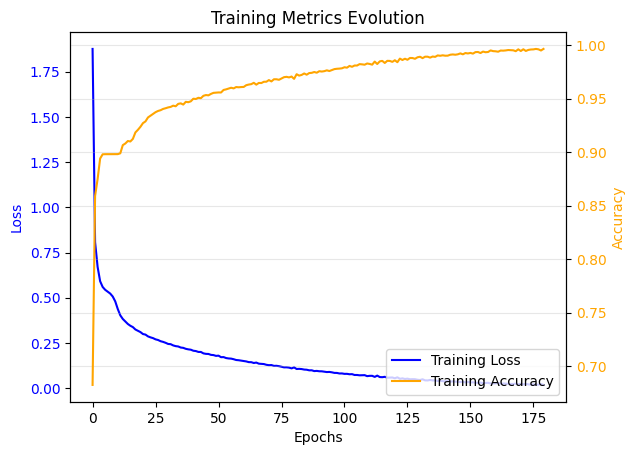

In [769]:
import matplotlib.pyplot as plt

ax1 = plt.gca()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(history.history['loss'], color='blue', label='Training Loss')

# Добавляем Validation Loss если есть
if 'val_loss' in history.history:
    ax1.plot(history.history['val_loss'], linestyle='--', color='deepskyblue', label='Validation Loss')

# Настраиваем цвет меток для Loss
ax1.tick_params(axis='y', labelcolor='blue')

# Создаем вторую ось для Accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='orange')
ax2.plot(history.history['accuracy'], color='orange', label='Training Accuracy')

# Добавляем Validation Accuracy если есть
if 'val_accuracy' in history.history:
    ax2.plot(history.history['val_accuracy'], linestyle='--', color='darkorange', label='Validation Accuracy')

# Настраиваем цвет меток для Accuracy
ax2.tick_params(axis='y', labelcolor='orange')

# Объединяем легенды с обеих осей
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title('Training Metrics Evolution')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# loo = LeaveOneOut()
# for fold_num, (train_index, test_index) in enumerate(loo.split(pad_statements)):
#     print(f'Фолд {fold_num + 1}')
#     X_train, X_test = pad_statements[train_index], pad_statements[test_index]
#     y_train, y_test = pad_tags[train_index], pad_tags[test_index]
    
#     model = build_model(input_dim, output_dim, output_units)
#     model.fit(x=X_train, y=y_train, batch_size=32, epochs=5)

Фолд 1
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.5474 - loss: 3.1102
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8315 - loss: 1.0077
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8672 - loss: 0.7714
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8782 - loss: 0.6749
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8881 - loss: 0.6087
Фолд 2
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.5438 - loss: 3.0130
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8379 - loss: 0.9983
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8582 - loss: 0.8118
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8865 - loss: 0.6515
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8702 - loss: 0.6746
Фолд 3
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.6107 - loss: 2.9898
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - 

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x00000190541C5C60>
Traceback (most recent call last):
  File "C:\Users\vlaxd\AppData\Local\Programs\Python\Python310\lib\weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.5539 - loss: 2.8569
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8312 - loss: 1.0071
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.8677 - loss: 0.7740
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8833 - loss: 0.6653
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.8803 - loss: 0.6378
Фолд 34
Epoch 1/5


KeyboardInterrupt: 

In [801]:
import numpy as np

preds = model_test.predict([test_states, test_poses])

pred_labels = np.argmax(preds, axis=-1)
test_labels = np.argmax(test_tags, axis=-1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 787ms/step


In [747]:
type(test_states)

numpy.ndarray

In [684]:
pred_labels

array([[ 0,  0,  0, ..., 68, 50, 50],
       [ 0,  0,  0, ..., 18, 50, 50],
       [ 0,  0,  0, ..., 50, 49, 50],
       ...,
       [ 0,  0,  0, ..., 50, 38, 50],
       [ 0,  0,  0, ..., 50, 39, 50],
       [ 0,  0,  0, ..., 50, 50, 50]], shape=(93, 50))

In [685]:
test_labels

array([[ 0,  0,  0, ..., 68, 50, 50],
       [ 0,  0,  0, ..., 44, 50, 50],
       [ 0,  0,  0, ..., 50, 49, 50],
       ...,
       [ 0,  0,  0, ..., 50, 68, 50],
       [ 0,  0,  0, ..., 50, 39, 50],
       [ 0,  0,  0, ..., 50, 50, 50]], shape=(93, 50))

In [794]:
mask = test_labels != 0 # маска для исключения значейний падинга при подсчете метрик качества

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

average = 'weighted'

accuracy = accuracy_score(test_labels[mask], pred_labels[mask])
     = precision_score(test_labels[mask], pred_labels[mask], average=average)
recall = recall_score(test_labels[mask], pred_labels[mask], average=average)
f1 = f1_score(test_labels[mask], pred_labels[mask], average=average)

metrics_df = pd.DataFrame(data = {'accuracy':accuracy, 
                           'precision':precision, 
                           'recall':recall, 
                           'f1':f1
                           }, index=[0])
metrics_df

c:\Users\vlaxd\OneDrive\Рабочий стол\4_course\hse-personal-data-anonymisation\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vlaxd\OneDrive\Рабочий стол\4_course\hse-personal-data-anonymisation\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision,recall,f1
0,0.903438,0.892179,0.903438,0.894137


In [588]:
s = '''
... - "Так в чем же дело?" - "Не ра-ду-ют".
... И т. д. и т. п. В общем, вся газета
... '''
s1 = ''' Всем привет!
Меня зовут Владислав!
18.02.2003!
'''
s2 = '''
...aef... поэтому я люблю ее!!!

Уфа мою любимый город!
'''
data = text2sentence(s2)
data

['\n...aef... поэтому я люблю ее!!!', '\n\nУфа мою любимый город!\n']

In [564]:
list(sentenize(s1))

[Substring(1, 13, 'Всем привет!'),
 Substring(14, 35, 'Меня зовут Владислав!'),
 Substring(36, 47, '18.02.2003!')]

In [575]:
temp1 = sentenize(s1)
temp2 = sentenize(s1)
a = len(list(temp2))
for i,s in enumerate(temp1):
    if i ==  len(list(temp1)) - 1:
        print('he')
    print(i)

0


In [ ]:
t = 'Меня зовут Платонов Владислав Алексеевич. Я люблю играть в футбол'

data = text2sentence(t)
data = sentence2word(data[0])
print(data)
data_pad = pad_sequences([word[2] for word in data], maxlen=max_len_statement)
print(data_pad)

[(0, 4, 'Меня'), (4, 5, ' '), (5, 10, 'зовут'), (10, 11, ' '), (11, 19, 'Платонов'), (19, 20, ' '), (20, 29, 'Владислав'), (29, 30, ' '), (30, 40, 'Алексеевич'), (40, 41, '.')]


ValueError: invalid literal for int() with base 10: 'Меня'

In [ ]:
model = build_model(input_dim_states, input_dim_poses, output_dim, output_units)
model.fit([pad_statements, pad_poses], pad_tags, batch_size=32, epochs=180)

Epoch 1/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - accuracy: 0.5842 - loss: 2.4948
Epoch 2/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8688 - loss: 0.7707
Epoch 3/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8877 - loss: 0.6011
Epoch 4/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9103 - loss: 0.5125
Epoch 5/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9057 - loss: 0.5129
Epoch 6/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9043 - loss: 0.5037
Epoch 7/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9044 - loss: 0.4915
Epoch 8/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9001 - loss: 0.4945
Epoch 9/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9015 - loss: 0.4493
Epoch 10/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9046 - loss: 0.3889
Epoch 11/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9062 - loss: 0.3879
Epoch 12/180
15/15 ━━━━━━━━━━━━━━━━━━━━ 

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Saver'

In [ ]:
model.save('model.keras')

In [709]:
from tensorflow.keras.models import load_model
model1 = load_model('model.keras')

In [730]:
def fill_words(sent):
        words_all = [] # слова по предложениям [[word1, word2]][[word1]][[word1]]
        starts_all = []
        ends_all = []
        for sentence in sent:
            custom_pattern = re.compile(r"[A-Za-zА-Яа-яЁё]+|\d+|[^\w\s]|\s")
            matches = list(custom_pattern.finditer(sentence))
            starts = [match.start() for match in matches]
            ends = [match.end() for match in matches]
            matchs = [match.group() for match in matches]
            starts_all.append(starts)
            ends_all.append(ends)
            words_all.append(matchs)
            
        print(starts_all)
        print(ends_all)
        print(words_all)

In [731]:
sent = ['\n... - "Так в чем же дело?"', ' - "Не ра-ду-ют".\n...', ' И т. д. и т. п.', ' В общем, вся газета\n... ']
fill_words(sent)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 21, 25, 26], [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 8, 9, 10, 13, 14, 20, 21, 22, 23, 24]]
[[1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 21, 25, 26, 27], [1, 2, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], [1, 2, 3, 8, 9, 10, 13, 14, 20, 21, 22, 23, 24, 25]]
[['\n', '.', '.', '.', ' ', '-', ' ', '"', 'Так', ' ', 'в', ' ', 'чем', ' ', 'же', ' ', 'дело', '?', '"'], [' ', '-', ' ', '"', 'Не', ' ', 'ра', '-', 'ду', '-', 'ют', '"', '.', '\n', '.', '.', '.'], [' ', 'И', ' ', 'т', '.', ' ', 'д', '.', ' ', 'и', ' ', 'т', '.', ' ', 'п', '.'], [' ', 'В', ' ', 'общем', ',', ' ', 'вся', ' ', 'газета', '\n', '.', '.', '.', ' ']]


In [732]:
d = {1:0, 2:100}

for k, v in d.items():
    print(f'{k} {v}')

1 0
2 100


In [761]:
import os
relative_path = 'known_tokens_poses_tags.json'
print(os.path.abspath(relative_path))

c:\Users\vlaxd\OneDrive\Рабочий стол\4_course\hse-personal-data-anonymisation\src\known_tokens_poses_tags.json
